In [1]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import math
from matplotlib.animation import FuncAnimation
from lmfit import minimize, fit_report, Parameters
from aim2_population_model_spatial_aff_parallel import get_mod_spike
from model_constants import (MC_GROUPS, LifConstants)
from popul_model import pop_model
from aim2_population_model_spatial_aff_parallel import Afferent, SimulationConfig, Simulation
import os 

2025-05-16 10:48:40,105 - DEBUG - Importing LIF model...
2025-05-16 10:48:40,105 - DEBUG - LIF model imported successfully


### Model Parameters

In [2]:
# lmpars_init_dict = {}
# lmpars = Parameters()
# lmpars.add('tau1', value=8, vary=False) #tauRI()
# lmpars.add('tau2', value=200, vary=False) #tauSI
# lmpars.add('tau3', value=1744.6, vary=False)#tau USI
# lmpars.add('tau4', value=np.inf, vary=False)
# lmpars.add('k1', value=.74, vary=False, min=0) #a constant
# lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
# lmpars.add('k3', value=.07, vary=False, min=0) #c constant
# lmpars.add('k4', value=.0312, vary=False, min=0)
# lmpars_init_dict['t3f12v3final'] = lmpars

# Global Variables
lmpars_init_dict = {}
lmpars = Parameters()
lmpars.add('tau1', value=8, vary=False) #tauRI(ms)
lmpars.add('tau2', value=200, vary=False) #tauSI(ms)
lmpars.add('tau3', value=1744.6, vary=False)#tauUSI(ms)
lmpars.add('tau4', value=np.inf, vary=False)
lmpars.add('k1', value=.74, vary=False, min=0) #a constant
lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
lmpars.add('k3', value=.07, vary=False, min=0) #c constant
lmpars.add('k4', value=.0312, vary=False, min=0)
lmpars_init_dict['t3f12v3final'] = lmpars

### Population Model Class with methods for Raidal & Spatial Model and Plotting funtino for radial

In [2]:
class VF_Population_Model:
    
    def __init__(self, vf_tip_size, aff_type, scaling_factor, density = None):
        self.sf = scaling_factor 
        self.vf_tip_size = vf_tip_size
        self.aff_type = aff_type
        self.results = None
        self.stress_data = None
        self.x_coords = None
        self.y_coords = None
        self.time_of_firing = None
        self.radial_stress_data = None
        self.radial_iff_data = None
        self.SA_radius = None
        self.g = None
        self.h = None
        self.density = density.lower().capitalize() if density else None

    """
        functino takes in a vf_tip_size (given that that there is data assicated with it) an
        afferent type, and runs the single unit model for all of those coordinates with the data

        firing time: takes either pike or a certain time, during thd ramp phase when the 
        
    """
    def spatial_stress_vf_model(self, time_of_firing = "peak", g=0.2, h= .5):
        self.time_of_firing = time_of_firing
        self.g = g
        self.h = h


        #in the case that a desnity is not specified
        coords = None
        stress_data = None
        if not self.density:
            if self.vf_tip_size == 4.56:    
                coords = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
            else:
                coords = pd.read_csv(f"data/P4/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")

        elif self.density == "Low" or self.density == "Medium" or self.density == "High" or self.density == "Realistic":
            if self.vf_tip_size == 4.56:    
                coords = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
            else:
                coords = pd.read_csv(f"data/P4/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
        else:   
            logging.error(f"Density is not specified correctly Density Specified : {self.density}")
            return


        #assinging the instance variables for all the x coords and y coords of spatial points
        self.x_coords = [float(row[0]) for row in coords.iloc[0:].values]
        self.y_coords = [float(row[1]) for row in coords.iloc[0:].values]

        

        if not self.density:
            if self.vf_tip_size == 4.56:    
                stress_data = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
            else:
                stress_data = pd.read_csv(f"data/P4/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
        elif self.density == "Low" or self.density == "Medium" or self.density == "High" or self.density == "Realistic":
            if self.vf_tip_size == 4.56:        
                stress_data = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
            else:
                stress_data = pd.read_csv(f"data/P4/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
        else:
            logging.error(f"Density is not specified correctly Density Specified : {self.density}")
            
            return

        time = stress_data['Time (ms)'].to_numpy()

        afferent_type = []
        x_pos = []
        y_pos = []
        spikes = []
        mean_firing_frequency = []
        peak_firing_frequency = []
        first_spike_time = []
        last_spike_time = []
        stress_trace = []
        cumulative_mod_spike_times = []
        entire_iff = []
        #iterating through each of the coordinates
        for i, row in coords.iloc[0:].iterrows():
            i+=1 #incrementing so index starts from first index
            # print(f"index: {i}, row: {row}")
            #getting stress data

            
            if f"Coord {i} Stress (kPa)" in stress_data.columns:
                stress = stress_data[f"Coord {i} Stress (kPa)"] * self.sf

                #Debugging Statement
                # print(f"RECIEVING STRESS DATA AT COORD {i} at x:{row.iloc[0]}and y:{row.iloc[1]} MEAN STRESS IS {np.mean(stress)}")
            else:
                # logging.warning("STRESS VALUE COULD NOT BE INDEXED")
                pass

            lmpars = lmpars_init_dict['t3f12v3final']
            if self.aff_type == "RA":
                # lmpars['tau1'].value = 2.5
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0

            groups = MC_GROUPS
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress, g=self.g,h =self.h )
            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                # logging.warning(f"SPIKES COULD NOT BE GENERATED FOR COORD {i} and X: {row.iloc[0]} and Y:{row.iloc[1]}, BECAUSE STRESS WAS TOO LOW")
                continue

            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            features, _ = pop_model(mod_spike_time,mod_fr_inst_interp)
    
            #appending stuff to lists
            afferent_type.append(self.aff_type)
            x_pos.append(row.iloc[0])
            y_pos.append(row.iloc[1])
            spikes.append(mod_spike_time)
            entire_iff.append(mod_fr_inst_interp)
            mean_firing_frequency.append(features["Average Firing Rate"])
            if time_of_firing == "peak":
                # Find the peak firing frequency and its time
                peak_fr = np.max(mod_fr_inst_interp)
                peak_fr_idx = np.argmax(mod_fr_inst_interp)
                peak_fr_time = mod_spike_time[peak_fr_idx] if peak_fr_idx < len(mod_spike_time) else None
                peak_firing_frequency.append(peak_fr)
                logging.warning(f"PEAK FIRING FREQUENCY: {peak_fr} at time {peak_fr_time} ms")
            else:
                #firing frequency at a specific time , finds the closest iff value to the specified time 
                # Find the index of the mod_spike_time closest to time_of_firing
                # closest_spike_idx = np.argmin(np.abs(np.array(mod_spike_time) - time_of_firing))
                #////// Newcode
  
                # Compute the difference array
                difference_array = time_of_firing - np.array(mod_spike_time)

                # Find the indices where the spike times are less than the time of firing
                positive_indices = np.where(difference_array > 0)[0]

                # Check if there are valid indices
                if len(positive_indices) > 0:
                    # Get the index of the closest spike time (less than the time of firing)
                    closest_spike_idx = positive_indices[np.argmin(difference_array[positive_indices])]

                    # Use the closest index to append the value
                    temp_fr_inst_interp = mod_fr_inst_interp[closest_spike_idx]
                else:
                    # Handle the case where no spike times are less than the time of firing
                    temp_fr_inst_interp = 0  # or some default value, depending on your requirements






                # # Debugging Statements
                # print(f"MOD_SPIKE_TIME:{mod_spike_time}")
                # print(f"TIME_OF_FIRING: {mod_fr_inst_interp}")
                # print(f"MOD_SPIKE_TIME_SHAPE: {len(mod_spike_time)}")
                # print(f"MOD_FR_INST_INTERP_SHAPE: {len(mod_fr_inst_interp)}")
                # # print(f"Closest Spike Index: {closest_spike_idx}")
                # print(f"IFF OF 1st FIRING: { mod_fr_inst_interp[0]}")
                # if len(mod_spike_time) > 1:
                #     print(f"IFF OF 2nd FIRING: {mod_fr_inst_interp[1]}")
                
                # Get the corresponding mod_fr_inst_interp value tied to this spike time
                # temp_fr_inst_interp = mod_fr_inst_interp[closest_spike_idx]
                # Append the instantaneous firing frequency at the closest spike time
                peak_firing_frequency.append(temp_fr_inst_interp)

            # print(f"mod_spike_time {mod_spike_time}")
        
            first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != None else None)
            last_spike_time.append(mod_spike_time[-1])
            stress_trace.append(stress)
            # logging.warning(f"MOD_FR_INST_INTERP_SHAPE: {mod_fr_inst_interp}")
            cumulative_mod_spike_times.append(mod_spike_time)
            
        model_results = {
            'afferent_type': self.aff_type,
            'x_position': x_pos,
            'y_position': y_pos,
            'spike_timings' : spikes,
            'mean_firing_frequency' : mean_firing_frequency,
            'peak_firing_frequency' : peak_firing_frequency, 
            'first_spike_time': first_spike_time,
            'last_spike_time' : last_spike_time,
            'each_coord_stress': stress_trace, 
            'entire_iff' : entire_iff,
            'cumulative_mod_spike_times': cumulative_mod_spike_times
        }

        self.results = model_results
        return model_results

    def radial_stress_vf_model(self,g= 0.2, h= .5):

        """ Read in the Radial which has sample stress traces for every 2mm from a center point
        to calculate firing"""
        self.g = g
        self.h = h

        #regex pattern for exstracting the distance from the middle point
        distance_regex = r'\d\.\d{2}'

        radial_stress = None
        if not self.density:
            if self.vf_tip_size == 4.56:        

                radial_stress = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_radial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
            else:
                radial_stress = pd.read_csv(f"data/P4/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_radial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
        elif self.density == "Low" or self.density == "Medium" or self.density == "High" or self.density == "Realistic":
            print(f"Reading in data for {self.density} density")
            if self.vf_tip_size == 4.56:        
                radial_stress = pd.read_csv(f"data/P3/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_radial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
            else:
                radial_stress = pd.read_csv(f"data/P4/{self.density}/{self.vf_tip_size}/{self.vf_tip_size}_radial_stress_corr_{self.density.lower() if self.density!="Medium" else "med"}.csv")
        else:
            logging.error(f"Density is not specified correctly Density Specified : {self.density}")
            return
        radial_time = radial_stress['Time (ms)'].to_numpy()
        
        stress_data = {}
        iff_data = {}
        not_generated_radii = []

        logging.warning(f"LENGTH OF radial_stress.columns: {len(radial_stress.columns)}")
        # Inner loop to iterate through radial distances
        for col in radial_stress.columns[1:]:

            
            LifConstants.set_resolution(1)
            matches = re.findall(distance_regex, col)
            if matches:
                distance_from_center = float(matches[0])
            else:
                logging.error(f"NO MATCHES FOUND FOR {col}")
                continue #skipts the current column and proceeds to the next

            # Initialize lists for each coordinate-distance pair
            afferent_type = []
            spikes = []
            mean_firing_frequency = []
            peak_firing_frequency = []
            first_spike_time = []
            last_spike_time = []

            # if radial_spatial_flag:
            #     radial_stress_vals = radial_stress[col]
            #     radial_stress_max = np.max(radial_stress_vals)
            #     distance_scaling_factor = spatial_stress_max / radial_stress_max
            #     radial_spatial_flag = False
            
            #where the scaling happens
            scaled_stress = radial_stress[col] *  self.sf

            stress_data[distance_from_center] = {
                "Time": radial_time,
                distance_from_center: scaled_stress.to_numpy()
            }

            lmpars = lmpars_init_dict['t3f12v3final']
            if afferent_type == "RA":
                # lmpars['tau1'].value = 2.5
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0

            groups = MC_GROUPS
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, stress_data[distance_from_center]["Time"], stress_data[distance_from_center][distance_from_center],g=self.g, h = self.h)

            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                # logging.warning(f"SPIKES COULD NOT BE GENERATED FOR {self.vf_tip_size}")
                not_generated_radii.append(distance_from_center)
                iff_data[distance_from_center] = None
                continue

            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, radial_time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            features, _ = pop_model(mod_spike_time, mod_fr_inst_interp)

            # Append single values to the lists
            afferent_type.append(afferent_type)
            spikes.append(len(mod_spike_time) if len(mod_spike_time) != 0 else None)
            mean_firing_frequency.append(features["Average Firing Rate"])
            peak_firing_frequency.append(np.max(mod_fr_inst_interp))
            first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != 0 else None)
            last_spike_time.append(mod_spike_time[-1])

            # Store each coordinate-distance dictionary within iff_data
            iff_data[distance_from_center] = {
                'afferent_type': afferent_type,
                'num_of_spikes': spikes[0],
                'mean_firing_frequency': mean_firing_frequency[0],
                'peak_firing_frequency': peak_firing_frequency[0],
                'first_spike_time': first_spike_time[0],
                'last_spike_time': last_spike_time[0]
            }
        logging.warning(f"stress_data: {stress_data}")
        self.radial_stress_data = stress_data
        self.radial_iff_data = iff_data

    def plot_spatial_coords(self, plot = False):
        """
        Plots the iffs on a grid for the original n points, the magniude of the peak firing
        frequency directly affects the size of the circle plotted, and the opacity
        """
        #colors for differnet afferents
        colors = {'SA': '#31a354', 'RA': '#3182bd'}
        plt.figure(figsize=(12, 8))

        # Plot the stimulus locations as circles
        x_positions = self.results.get("x_position")
        y_positions = self.results.get("y_position")
        mean_iffs = self.results.get("mean_firing_frequency")
        peak_iffs = self.results.get("peak_firing_frequency")
        spike_timings = self.results.get("spike_timings")
        entire_iff = self.results.get("entire_iff")

        # print(f"peak_iffs len {len(peak_iffs)}")
        # for x,y, peak in zip(x_positions, y_positions, peak_iffs):
        #     print(f"x: {x} y: {y} peak_iff: {peak* 1e3}")
            
    
        x_positions = [float(value) for value in x_positions]
        y_positions = [float(value) for value in y_positions]
        #scaling peak_iffs so it looks better when plotting

        # for time, iff, peak_iff in zip(spike_timings, entire_iff, peak_iffs):
        #     print(f"Time: {time} IFF: {iff}, PEAK: {peak_iff}")
            
        alphas = [float(value) / max(peak_iffs) if value != 0 else 0 for value in peak_iffs]    
  
        #Scatter plot
        # Plot the stimulus locations as circles
        for x_pos, y_pos, radius, alpha in zip(x_positions, y_positions, peak_iffs, alphas):
            print(f"plotting {x_pos} {y_pos} {radius} {alpha}")
            plt.gca().add_patch(
                patches.Circle((x_pos, y_pos), radius*2, edgecolor='black', facecolor = colors.get(self.aff_type) , linewidth=1, alpha = 0.5)
            )
        
        #calculating the Stimulus Point
        idx_of_max_iff = mean_iffs.index(np.max(mean_iffs))
        x_stim = x_positions[idx_of_max_iff]
        y_stim = y_positions[idx_of_max_iff]

        #plotting the circle where the center is the point of max stimulus
        # plt.gca().add_patch(
        #     patches.Circle((x_stim,y_stim),self.SA_Radius, edgecolor='black', facecolor='none', linewidth=1) 
        # )

        if plot:
            plt.xlabel('Length (mm)')
            plt.ylabel('Width (mm)')
            plt.title(f"{self.density if self.density else ''} {self.vf_tip_size} VF {self.aff_type} firing at {self.time_of_firing} ms Stress Distribution")
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.xlim(4,12)
        plt.ylim(2,7)
        # Set major ticks for every 1 unit on both axes
        plt.xticks(range(4, 13), fontsize=32)  # 4 to 12 inclusive with larger font
        plt.yticks(range(2, 8), fontsize=32)   # 2 to 7 inclusive with larger font
        # Set minor ticks for every 0.5 unit on both axes
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
        plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.5))


        plt.show()

        # plt.savefig(f"vf_graphs/aggregated_results_on_grid/{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")
        plt.savefig(f"vf_graphs/spatial_plots/{self.density if self.density else ''}{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")


    '''
    In order to run this instace method, the following  three methods must have been already run 
        vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
        vf_model.radial_stress_vf_model(.2,.5)
        vf_model.run_single_unit_model_combined_graph()

    '''
    @staticmethod
    def cumulative_afferent_over_time(afferent_type, plot_cumulative=True, vf_tip_sizes=[3.61, 4.17, 4.56], colors=['red', 'blue', 'green'], density=None):
        labels = [f"Tip Size {size}" for size in vf_tip_sizes]

        # Create a single figure
        plt.figure(figsize=(10, 6))
        vf_cumulative_data = {}
        for vf_tip, color, label in zip(vf_tip_sizes, colors, labels):
            print(f"VF_TIP: {vf_tip}")
            # Initialize the VF model for each tip size
            vf_model = VF_Population_Model(vf_tip, afferent_type, scaling_factor=1.0, density=density)
            vf_model.radial_stress_vf_model(g =.2 if afferent_type =="SA" else .4 , h =.5 if afferent_type =="SA" else .1)
            vf_model.run_single_unit_model_combined_graph(plot=False)

            # Get model results
            model_results = vf_model.spatial_stress_vf_model()
            first_spike_times = model_results["first_spike_time"]
            spike_timings = model_results["spike_timings"]
            # print(f"Spike_timings: {spike_timings}")
            first_spike_times = []


            spike_timings = model_results["spike_timings"]
            for st in spike_timings:
                if len(st)>1:
                    # print(st[1])
                    first_spike_times.append(st[1])
                    print(f"Spike Timings length: {len(st[1:])}")
            


            #soring based on zipped 
            zipped = list(zip(first_spike_times, model_results["x_position"], model_results["y_position"]))
            sorted_zipped = sorted(zipped, key = lambda x: x[0])
            sorted_spike_times, sorted_x_positions, sorted_y_positions = zip(*sorted_zipped)
            
            # print (f"first_spike_times: {sorted_spike_times}")
            # print(f"x_positions: {sorted_x_positions}")
            # print(f"y_positions: {sorted_y_positions}")
            # entire_iff = model_results["entire_iff"]
            # for iff in entire_iff:
            #     if len(iff) > 1:
            #         print(f"IFF: {iff[1]}")
            #         print(f"IFF: {iff[1]}")
            # print(f"All Spikes: {model_results["cumulative_mod_spike_times"]}")
            

            # Dictionary to store the count of afferents recruited over time
            time_and_afferents_triggered = {}

            # Count the number of afferents recruited at each spike time
            for spike_time in first_spike_times:
                if spike_time in time_and_afferents_triggered.keys():
                    time_and_afferents_triggered[spike_time] += 1
                else:
                    time_and_afferents_triggered[spike_time] = 1

            # Sort the dictionary by spike times
            spike_times_sorted = sorted(time_and_afferents_triggered.keys())
            time_and_afferent_keys_sorted = {time_stamp: time_and_afferents_triggered[time_stamp] for time_stamp in spike_times_sorted}

            # Logic for cumulative summation of afferents over time
            cumulative_afferents = {}
            cumulative_counter = 0
            for time in time_and_afferent_keys_sorted.keys():
                cumulative_counter += time_and_afferents_triggered[time]
                cumulative_afferents[time] = cumulative_counter

            # Plot cumulative or instantaneous data
            if plot_cumulative:

                plt.plot(cumulative_afferents.keys(), cumulative_afferents.values(), marker='o', color=color, label=label)
            else:
                plt.scatter(time_and_afferents_triggered.keys(), time_and_afferents_triggered.values(), marker='o', color=color, label=label)

            vf_cumulative_data[vf_tip] = cumulative_afferents
        # Add labels, legend, and grid
        if not density:
            plt.title(f"{density if density else ''} DensityCumulative Afferents Over Time" if plot_cumulative else "Instantaneous Afferents Over Time", fontsize=14, fontweight="bold")


        plt.xlabel("Time (ms)", fontsize=12)
        plt.ylabel("Number of Afferents Recruited", fontsize=12)
        plt.grid(alpha=0.5)
        plt.legend(title="VF Tip Sizes")
        plt.tight_layout()
        plt.title(f"Cumulation of {afferent_type} Afferents")
        plt.savefig(f"vf_graphs/furthest_difference_before_firing/cumu_afferents_time/{density if density else ''}_{afferent_type}_cumulative_afferents.png", bbox_inches='tight')
        # plt.show()
        return vf_cumulative_data

    '''
    In order to run this instace method, the following  three methods must have been already run 
        vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
        vf_model.radial_stress_vf_model(.2,.5)
        vf_model.run_single_unit_model_combined_graph()

    '''
    @staticmethod
    def cumulative_firing_over_time(afferent_type = None, cumulative=True, vf_tip_sizes=[3.61, 4.17, 4.56], colors=['red', 'blue', 'green'], density = None):
        labels = [f"Tip Size {size}" for size in vf_tip_sizes]
        
        plt.figure(figsize=(10, 6))
        
        for vf_tip, color, label in zip(vf_tip_sizes, colors, labels):
            print(f"VF_TIP: {vf_tip}")
            vf_model = VF_Population_Model(vf_tip, afferent_type, scaling_factor=1.0, density=density.lower().capitalize())
            vf_model.radial_stress_vf_model(0.2, 0.5)
            vf_model.run_single_unit_model_combined_graph(plot = False)

            # Get model results
            model_results = vf_model.spatial_stress_vf_model()
            mod_spikes = model_results["spike_timings"]
            entire_iff = model_results["entire_iff"]

            # Creating a dict of {spike_times: firing at that time}
            spike_times_and_iffs = {}
            for spike_time_at_point, iff_at_point in zip(mod_spikes, entire_iff):
                for spike_time, iff in zip(spike_time_at_point, iff_at_point):
                    if spike_time in spike_times_and_iffs.keys():
                        spike_times_and_iffs[spike_time] += (iff * 1e3)
                    else:
                        spike_times_and_iffs[spike_time] = (iff * 1e3)


            # Sorting the dictionary by spike_times
            spike_times_sorted = sorted(spike_times_and_iffs.keys())
            spike_times_and_iffs = {time_stamp: spike_times_and_iffs[time_stamp] for time_stamp in spike_times_sorted}

            # Logic for calculating cumulative firing
            cumulative_iffs = {}
            cumulative_counter = 0
            for time in spike_times_and_iffs.keys():
                cumulative_counter += spike_times_and_iffs[time]
                cumulative_iffs[time] = cumulative_counter

            # Plotting cumulative or instantaneous firing
            if cumulative:
                plt.scatter(cumulative_iffs.keys(), cumulative_iffs.values(), marker='o', color=color, label=label)
            else:
                plt.scatter(spike_times_and_iffs.keys(), spike_times_and_iffs.values(), marker='o', color=color, label=label)

        # Add labels, legend, and grid
        plt.title(f"{density if density else ''} Density Cumulative IFFs Over Time" if cumulative else "Instantaneous IFFs Over Time", fontsize=14, fontweight="bold")
        plt.xlabel("Time (ms)", fontsize=12)
        plt.ylabel("Total Firing Frequency", fontsize=12)
        plt.grid(alpha=0.5)
        plt.legend(title="VF Tip Sizes")
        plt.tight_layout()
        plt.show()



    def run_single_unit_model_combined_graph(self, stress_threshold = 0, plot = True):
        
        #variable for The radius for SA, setting it to a really large variable
        SA_radius = 0
        if plot:
            fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Changed to 2 rows instead of 5
            fig.subplots_adjust(hspace=0.5, wspace=0.4)

            axes = axes.flatten()

        # finding comon limits
        common_x_min = 0
        common_x_max = max(data['Time'][-1] for data in self.radial_stress_data.values())
        common_stress_max =0 
        xommon_iff_max = 0 

        legend = False
        # Iterate through each entry in the stress_data dictionary and each subplot
        for idx, (distance, data) in enumerate(self.radial_stress_data.items()):
            if idx >= 10:  # Only plot up to 10 entries for the 2x5 grid
                break
            
            time = data['Time']  # Extract the time array
            stress_values =  data[distance]  # Apply scaling factor


            lmpars = lmpars_init_dict['t3f12v3final']
            LifConstants.set_resolution(1)
            if self.aff_type == "RA":
                # lmpars['tau1'].value = 2.5  #this is the original value
                lmpars['tau1'].value = 8
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0

            groups = MC_GROUPS

            ####added streses threshold logic 
            if np.max(stress_values) < stress_threshold:
                # Zero out the stress trace
                stress_values = np.zeros_like(stress_values)    



            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress_values,g= self.g,h= self.h )


            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                # logging.warning(f"SPIKES COULD NOT BE GENERATED for distance {distance}")
                
                continue
            #updating the size rf of the stimlus 
            if distance > SA_radius:
                    SA_radius = distance
            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst
            

            #logic for getting the iff values at at around 2 seconds
            # if distance == 0.0:
            #     for spike_time,iff in zip(mod_spike_time, mod_fr_inst_interp):
            #         if spike_time >= 1750 and spike_time <= 2250:
            #             print(f"Time (ms): {spike_time} Stress (kPa):{stress_values[int(spike_time)]} IFF (hz): {iff*1e3}")

            #addding the logic for the limits of stress and iff
            if not legend:
                common_stress_max = np.max(stress_values)+50
                common_iff_max = np.max(mod_fr_inst_interp*1e3)+50
            
            if plot:
                ax = axes[idx]
                ax2 = ax.twinx()  # Create twin axis on the right

                # Plot IFF (Hz) on the left y-axis
                ax.plot(mod_spike_time, mod_fr_inst_interp * 1e3, label="IFF (Hz)", 
                        marker='o', linestyle='none', color='blue')
                # ax.set_ylabel('Firing Rate (Hz)', color='blue')
                ax.tick_params(axis='y', labelcolor='blue')
                if self.vf_tip_size == 3.61:
                    ax.set_ylim(0, 525)
                elif self.vf_tip_size == 4.17:
                    ax.set_ylim(0, 525)
                elif self.vf_tip_size == 4.31:
                    ax.set_ylim(0, 525)
                elif self.vf_tip_size == 4.56:
                    ax.set_ylim(0, 525)

                # Plot Stress (kPa) on the right y-axis
                ax2.plot(time, stress_values, label="Stress (kPa)", color='red')
                # ax2.set_ylabel('Stress (kPa)', color='red')
                ax2.tick_params(axis='y', labelcolor='red')
                if self.vf_tip_size == 3.61:
                    ax2.set_ylim(0, 400)
                elif self.vf_tip_size == 4.17:
                    ax2.set_ylim(0, 400)
                elif self.vf_tip_size == 4.31:
                    ax2.set_ylim(0, 400)
                elif self.vf_tip_size == 4.56:
                    ax2.set_ylim(0, 400)


                # Title and X-axis
                ax.set_title(f'Distance {distance:.2f} mm')
                ax.set_xlabel('Time (ms)')
                ax.set_xlim(common_x_min, common_x_max)
                if not legend:
                    axes[idx].legend()
                    ax.set_ylabel('Firing Rate (Hz)', color='blue')
                    ax2.set_ylabel('Stress (kPa)', color='red')
                    legend= True

        if plot:
            # Hide any unused subplots
            for ax in axes[len(self.radial_stress_data):]:
                ax.axis('off')

            lmpars = lmpars_init_dict['t3f12v3final']
            tau1 = lmpars["tau1"]
            k1 = lmpars["k1"] #a value
            k2 = lmpars["k2"] #b value
            k3 = lmpars["k3"] #c value
            k4 = lmpars["k4"] #idk what this parameters is
            
            # plt.suptitle(
            #     f"Radial graph for Density {self.density} vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
            #     y = 0.92,
            #     fontsize = 26,
            #     fontweight = "bold"
                
            # )
            # Create directory if it doesn't exist
            os.makedirs("figure4", exist_ok=True)
            plt.savefig(f"figure4/radial_plots_{self.vf_tip_size}_{self.density if self.density else ''}_tauRI_{tau1.value}_g_{self.g}_h_{self.h}_a_{k1.value}_b_{k2.value}_c_{k3.value}.png")
            
        self.SA_Radius = SA_radius

    def sensitivity_analysis(self, parameter_of_variation,  stress_threshold = 0):
        #potential values
        #resetting parameters from previous sensitivty analysis if altered
        lmpars = lmpars_init_dict['t3f12v3final']
        lmpars["tau1"].value = 8
        lmpars["tau2"].value = 200
        lmpars["tau3"].value = 1744.6
        lmpars["tau4"].value = np.inf
        lmpars["k1"].value = .74
        lmpars["k2"].value = 2.75
        lmpars["k3"].value = .07
        lmpars["k4"].value = .0312

        sensitivity_values = []
        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            sensitivity_values = [1,2.5,8,30]
        elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
            sensitivity_values = [1,50,100,200, 250]
        elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
            sensitivity_values = [1,2,30,100]
        elif parameter_of_variation == "k1" or parameter_of_variation == "a":
            sensitivity_values = [10,20,30,40]
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            sensitivity_values = [2,4,8,16]
        elif parameter_of_variation == "g":
            sensitivity_values = [0.5, 0.75, 1.0, 1.25]
        elif parameter_of_variation == "h":
            sensitivity_values = [0, 0.25, 0.50, 0.75, 1.0]


        #variable for The radius for SA, setting it to a really large variable
        SA_radius = 0
        fig, axes = plt.subplots(5, 5, figsize=(20, 20))
        fig.subplots_adjust(hspace=0.5, wspace=0.4)
        axes = axes.flatten()

        colors = plt.cm.viridis(np.linspace(0,1,len(sensitivity_values)))

        # finding comon limits
        common_x_min = 0
        common_x_max = max(data['Time'][-1] for data in self.radial_stress_data.values())
        common_stress_max =0 
        xommon_iff_max = 0 

        legend = False
        # Iterate through each entry in the stress_data dictionary and each subplot


            #loop for all the square/ radii away from the stimuli   
        for idx, (distance, data) in enumerate(self.radial_stress_data.items()):
            if idx >= 25:  # Only plot up to 25 entries for the 5x5 grid
                break
            
            ax = axes[idx]
            ax2 = ax.twinx()  # Create twin axis on the right
            time = data['Time']  # Extract the time array
            stress_values = data[distance]  # Apply scaling factor

            for sv,color in zip(sensitivity_values,colors):
                # stress_values =  data[distance]  
                lmpars = lmpars_init_dict['t3f12v3final']
                LifConstants.set_resolution(1)
                if self.aff_type == "RA":
                    lmpars['tau1'].value = 2.5
                    lmpars['tau2'].value = 200
                    lmpars['tau3'].value = 1
                    lmpars['k1'].value = 35
                    lmpars['k2'].value = 0
                    lmpars['k3'].value = 0.0
                    lmpars['k4'].value = 0

                # Update the parameter value
                if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
                    lmpars["tau1"].value = sv
                elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
                    lmpars["tau2"].value = sv
                elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
                    lmpars["tau3"].value = sv
                elif parameter_of_variation == "k2" or parameter_of_variation == "b":
                    lmpars["k2"].value = sv
                elif parameter_of_variation == "k1" or parameter_of_variation == "a":
                    lmpars["k1"].value = sv
                elif parameter_of_variation == "g":
                    self.g = sv
                elif parameter_of_variation == "h":
                    self.h = sv
                


                groups = MC_GROUPS

                ####added streses threshold logic 
                if np.max(stress_values) < stress_threshold:
                    # Zero out the stress trace
                    stress_values = np.zeros_like(stress_values)    

                ####
                mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress_values,g= self.g,h= self.h )


                if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                    # logging.warning(f"SPIKES COULD NOT BE GENERATED for distance {distance}")
                    
                    continue
                #updating the size rf of the stimlus 
                if distance > SA_radius:
                        SA_radius = distance
                if len(mod_spike_time) != len(mod_fr_inst):
                    if len(mod_fr_inst) > 1:
                        mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                    else:
                        mod_fr_inst_interp = np.zeros_like(mod_spike_time)
                else:
                    mod_fr_inst_interp = mod_fr_inst

                #addding the logic for the limits of stress and iff
                if not legend:
                    common_stress_max = np.max(stress_values)+50
                    common_iff_max = np.max(mod_fr_inst_interp*1e3)+50


                # Plot IFF (Hz) on the left y-axis
                ax.plot(mod_spike_time, mod_fr_inst_interp * 1e3, label= sv,
                        linestyle='solid', color=color)
                # ax.set_ylabel('Firing Rate (Hz)', color='blue')
            ax.tick_params(axis='y', labelcolor='blue')
            if self.vf_tip_size == 3.61:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.17:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.31:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.56:
                ax.set_ylim(0, 525)

            # Plot Stress (kPa) on the right y-axis
            ax2.plot(time, stress_values, label="Stress (kPa)", color='red')
            # ax2.set_ylabel('Stress (kPa)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            if self.vf_tip_size == 3.61:
                ax2.set_ylim(0, 140)
            elif self.vf_tip_size == 4.17:
                ax2.set_ylim(0, 300)
            elif self.vf_tip_size == 4.31:
                ax2.set_ylim(0, 350)
            elif self.vf_tip_size == 4.56:
                ax2.set_ylim(0, 400)


            # Title and X-axis
            ax.set_title(f'Distance {distance:.2f} mm')
            ax.set_xlabel('Time (ms)')
            ax.set_xlim(common_x_min, common_x_max)
            if not legend:
                axes[idx].legend()
                ax.set_ylabel('Firing Rate (Hz)', color='blue')
                ax2.set_ylabel('Stress (kPa)', color='red')
                legend= True

        # Hide any unused subplots
        for ax in axes[len(self.radial_stress_data):]:
            ax.axis('off')

        lmpars = lmpars_init_dict['t3f12v3final']
        tau1 = lmpars["tau1"]
        k1 = lmpars["k1"] #a value
        k2 = lmpars["k2"] #b value
        k3 = lmpars["k3"] #c value
        k4 = lmpars["k4"] #idk what this parameters is
        

        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI:varying g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"     
            )
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:varying c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "g":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:varying h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "h":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:varying a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"   
            )
        elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )
        elif parameter_of_variation == "k1" or parameter_of_variation == "a":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:varying b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"
            )

        
        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: varying h:{self.h} g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:varying c:{k3.value}.png")   
        elif parameter_of_variation == "h":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:varying h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "g":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:varying a:{k1.value} b:{k2.value} c:{k3.value}.png")        
        elif parameter_of_variation == "tau2" or parameter_of_variation == "tauSI":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "tau3" or parameter_of_variation == "tauUSI":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "k1" or parameter_of_variation == "a":\
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.density if self.density else ''}_{self.vf_tip_size} tauRI: {tau1.value} g:{self.g} h:{self.h} a:varying b:{k2.value} c:{k3.value}.png")
    
        self.SA_Radius = SA_radius

    def radial_visualization_on_spatial_coords(self):
        colors = {'SA': '#31a354', 'RA': '#3182bd'}
        plt.figure(figsize=(12, 8))



        #formast of data, only really care about distance from center(iff_data.keys())and peak_firing_frequency (iff_data)
        # iff_data[distance_from_center] = {
        #     'afferent_type': afferent_type,
        #     'num_of_spikes': spikes[0],
        #     'mean_firing_frequency': mean_firing_frequency[0],
        #     'peak_firing_frequency': peak_firing_frequency[0],
        #     'first_spike_time': first_spike_time[0],
        #     'last_spike_time': last_spike_time[0]
        # }
        distance_data = self.radial_iff_data


        #plot the concentric black circle
        #plot the colored circle on the gird
        distances = [d for d in distance_data.keys() if distance_data[d] is not None]
        peak_iffs = [distance_data[distance]["peak_firing_frequency"] for distance in distances ]
        alphas = [float(value) / max(peak_iffs) if value != 0 else 0 for value in peak_iffs]



        for i, (distance, alpha,radius) in enumerate(zip(distances, alphas,peak_iffs)):

        
            #adding the concetring black circle
            plt.gca().add_patch(
            patches.Circle((0,0),distance, edgecolor='black', facecolor='none', linewidth=1, alpha = 0.5) 
            )



            #adding the smaller colored circle 
            sqrt_term = math.sqrt(distance **2 /2)
            plt.gca().add_patch(
            patches.Circle((sqrt_term, sqrt_term),radius, edgecolor='black', facecolor = colors.get(self.aff_type), linewidth=1, alpha = .5) 
            )

        plt.xlabel('Length (mm)')
        plt.ylabel('Width (mm)')
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.xlim(0,max(distances))
        plt.ylim(0,max(distances))
        # plt.axis('equal')
        plt.show()


    def get_SA_radius(self):
        return self.SA_Radius



### Generating the New Plot to be made into a Figure

In [ ]:
vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0, density="Realistic")
vf_model.radial_stress_vf_model()
vf_model.radial_visualization_on_spatial_coords()

### Doing a Sensitivity Analysis to tune different parameters

In [ ]:
sensitivity_variables = ["k1"]

vf_model = VF_Population_Model(3.61, "RA", scaling_factor= 1.0, density = "Med")

vf_model.radial_stress_vf_model(.4,1)

for var in sensitivity_variables:
    vf_model.sensitivity_analysis(var)

In [ ]:
tau1_values = [1,8,30,100]
k2_values = [2,4,8,16]
h_values = [0.1,0.2,0.3,0.4,0.5]
g_values = [0, 0.25, 0.50, 0.75, 1.0]

vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
lmpars = lmpars_init_dict['t3f12v3final']

for value in tau1_values:
    lmpars["tau1"].set(value = value)
    vf_model.radial_stress_vf_model()
for value in k2_values:
    lmpars["k2"].set(value = value)
    vf_model.radial_stress_vf_model()
for value in h_values:
    vf_model.radial_stress_vf_model(value, 1)
for value in g_values:
    vf_model.radial_stress_vf_model(.4, value)

### Normal Radial Model Plots

In [3]:
#Resetting the default parameters instead the senstivity analysis was done before
lmpars_init_dict = {}
lmpars = Parameters()
lmpars.add('tau1', value=8, vary=False) #tauRI(ms)
lmpars.add('tau2', value=200, vary=False) #tauSI(ms)
lmpars.add('tau3', value=1744.6, vary=False)#tauUSI(ms)
lmpars.add('tau4', value=np.inf, vary=False)
lmpars.add('k1', value=.74, vary=False, min=0) #a constant
lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
lmpars.add('k3', value=.07, vary=False, min=0) #c constant
lmpars.add('k4', value=.0312, vary=False, min=0)
lmpars_init_dict['t3f12v3final'] = lmpars

Reading in data for Realistic density
2025-05-16 10:48:55,765 - WARNING - LENGTH OF radial_stress.columns: 26
2025-05-16 10:48:55,766 - DEBUG - Starting stress to firing rate conversion...
2025-05-16 10:48:55,766 - DEBUG - Converting stress to current...
2025-05-16 10:48:55,769 - DEBUG - Current conversion complete
2025-05-16 10:48:55,769 - DEBUG - Getting spikes from current...
2025-05-16 10:48:55,809 - DEBUG - Converting spikes to instantaneous firing rate...
2025-05-16 10:48:55,810 - DEBUG - Converting spike time to firing rate...
2025-05-16 10:48:55,811 - DEBUG - Firing rate calculation complete
2025-05-16 10:48:55,811 - DEBUG - Firing rate conversion complete
2025-05-16 10:48:55,811 - DEBUG - Starting stress to firing rate conversion...
2025-05-16 10:48:55,812 - DEBUG - Converting stress to current...
2025-05-16 10:48:55,814 - DEBUG - Current conversion complete
2025-05-16 10:48:55,814 - DEBUG - Getting spikes from current...
2025-05-16 10:48:55,846 - DEBUG - Converting spikes to 

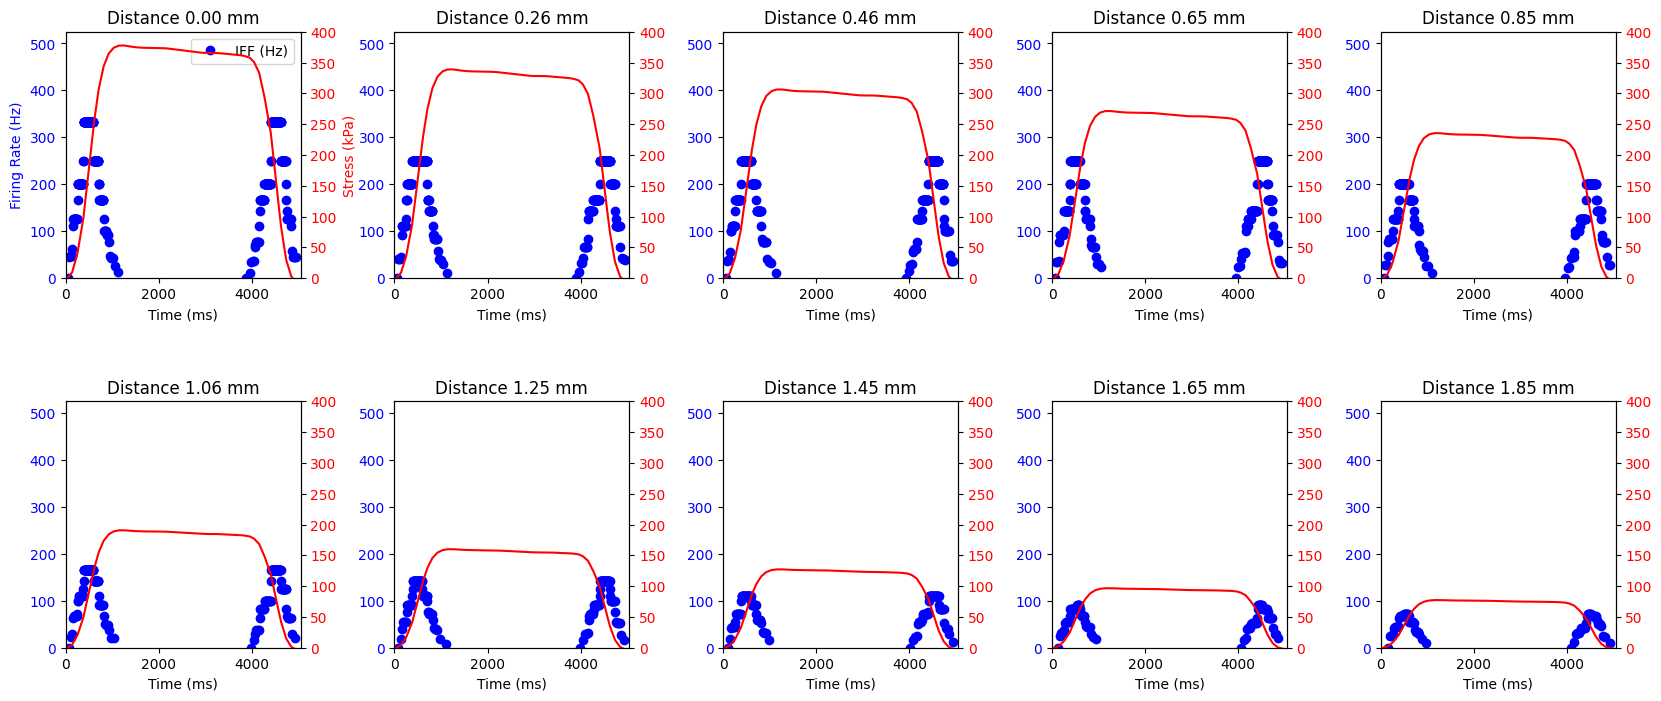

In [4]:
vf_model = VF_Population_Model(4.56, "RA", scaling_factor= 1.0, density="Realistic")
vf_model.radial_stress_vf_model()
vf_model.run_single_unit_model_combined_graph()

In [ ]:
VF_Population_Model.cumulative_firing_over_time(density = "High")

In [ ]:
vf_cumulative_SA = VF_Population_Model.cumulative_afferent_over_time(afferent_type="SA", density = "Realistic")


#### Generating the Spatial Plots

In [ ]:
for index, vf_tip in enumerate(vf_cumulative_SA.keys()):
    if index == 1:
        break
    for time_of_firing in vf_cumulative_SA[vf_tip].keys():
        vf_model = VF_Population_Model(vf_tip_size= vf_tip,aff_type= "SA", scaling_factor= 1.0, density="Realistic")
        vf_model.radial_stress_vf_model(g = .2, h = .5)
        vf_model.run_single_unit_model_combined_graph(plot=False)
        vf_model.spatial_stress_vf_model(time_of_firing= time_of_firing+1)
        vf_model.plot_spatial_coords()



In [ ]:
for density in ["Low", "Medium", "High", "Realistic"]:
    for af_type in ["SA"]:
        for vf_tip_size in [4.56]:
            for t_of_f in [100,200,300,400,500, "peak"]:
                vf_model = VF_Population_Model(vf_tip_size= vf_tip_size,aff_type= af_type, scaling_factor= 1.0, density=density)
                vf_model.radial_stress_vf_model(g = .2 if af_type == "SA" else .4, h = .5 if af_type == "SA" else .1)
                vf_model.run_single_unit_model_combined_graph(plot=False)
                vf_model.spatial_stress_vf_model(time_of_firing=t_of_f)
                vf_model.plot_spatial_coords(plot=False)

In [ ]:
vf_model = VF_Population_Model(vf_tip_size= 3.61,aff_type= "SA", scaling_factor= 1.0, density="Realistic")
vf_model.radial_stress_vf_model(g = .2, h = .5)
vf_model.run_single_unit_model_combined_graph(plot=False)
vf_model.spatial_stress_vf_model()
vf_model.plot_spatial_coords()

### Making the population Model over time plots

**Configuring the Von-Frey Population Model**

In [ ]:
iffs = vf_model.get_iffs()

for iff in iffs:
    print(iff)

**Randomly Generating Afferents and setting up the configuration for the Simulation**

In [ ]:
tongue_size = (10,18)  # in mm
density_ratio = (1, 0)  # Ratio of SA and RA afferents
n_afferents = 1500
rf_sizes = {
    'SA': [1],
    'RA': [1]
}

config = SimulationConfig(tongue_size, density_ratio, n_afferents, rf_sizes,
                          stimulus_diameter=None, 
                          x_stimulus=None, y_stimulus=None,
                          stress=None)

simulation = Simulation(config)

afferents = simulation.get_afferents()


**Getting Stress & Firing Data for the Afferents**

In [ ]:
stress_data = []
iff_data = []

stresses, iffs = vf_model.simulate_afferent_response(afferents)

**Creating The Plot**

In [ ]:
vf_model.plot_afferents(iffs, afferents)

In [ ]:
stress_results.get(4).get(0.0), 
iffs_results.get(4).get(0.0)

In [ ]:
iffs_results.get(3)